In [1]:
using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using StatsBase#, JLD
using PlotlyJS

### Approximate SyncRank with sparsified Laplacian 


MUN graph model

least eigval of Laplacian= 0.0015289443058207524
k = 194 vs nb edges= 

123
 
method: DPP(K) unif
least eigenvalue of sparsifier: 6.986394225322879e-5
least eigenvalue of sparsifier: 0.0021926736750587854
least eigenvalue of sparsifier: 0.0028528116597218043
least eigenvalue of sparsifier: 

0.00420818706838722
least eigenvalue of sparsifier: 0.007404340215531263
least eigenvalue of sparsifier: 0.00925745040569153
method: DPP(K) JL-LS
least eigenvalue of sparsifier: 4.2719831159838426e-5


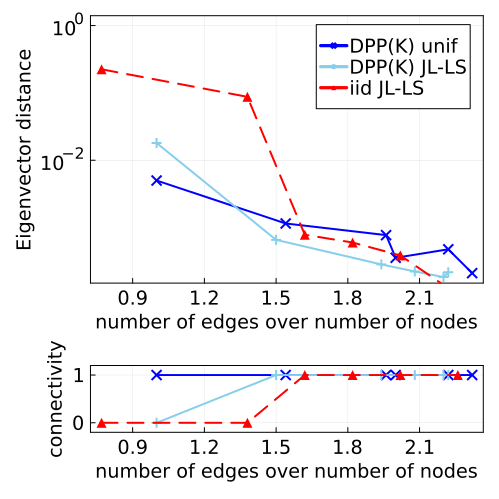

least eigenvalue of sparsifier: 0.001072210157035338
least eigenvalue of sparsifier: 0.0045264432065740285
least eigenvalue of sparsifier: 0.004748712852151955
least eigenvalue of sparsifier: 0.005999261763814273
least eigenvalue of sparsifier: 0.008479660927219773
method: iid JL-LS
least eigenvalue of sparsifier: 0.0001531987542907815
least eigenvalue of sparsifier: 0.0008114214167111356
least eigenvalue of sparsifier: 0.0008572366108180911
least eigenvalue of sparsifier: 0.0007897880543149243
least eigenvalue of sparsifier: 0.0009470556300927783
least eigenvalue of sparsifier: 0.0010008286985975327


"syncrank_err_MUNn50p0.1eta0.1q0"

In [181]:
type = "MUN" 

rng = Random.default_rng()

# graph parameters
n = 50#100
p = 0.1#0.9
eta = 1e-1#1e-3

# planted ranking score
planted_score = randperm(rng,n)

# graph model
if type=="MUN"
    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
elseif type=="ERO"
    meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
end

# simulation parameters
n_batch = 6 # maximum number of batches considered
n_rep = 1 # number of runs

# regularization parameter
q = 0

# storing settings
D_params = Dict("n" => n,"p" => p,"eta" => eta,"q" => q,"n_batch" => n_batch,"n_rep" => n_rep)

methods = [
    "DPP(K) unif",
    "DPP(K) JL-LS",
    #"DPP(K) LS",
    "iid JL-LS",
    # "iid LS",
    #"ST JL-LS",
    # "ST LS",
]

D_results = benchmark_syncrank(meta_g,planted_score, n_batch, n_rep, rng; methods)

# plotting distance between eigenvectors
check_connected = true
metric= "err"
y_limits = (1.5*1e-4, 1.4)
legendposition=:topright
plot_comparison_sync(metric,D_results,y_limits;legendposition,methods,check_connected)
name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# # saving plot
# savefig("figures/"*name*".pdf")

# # saving results
# save("figures/"*name*"_data.jld", "D_results", D_results,"D_params", D_params)

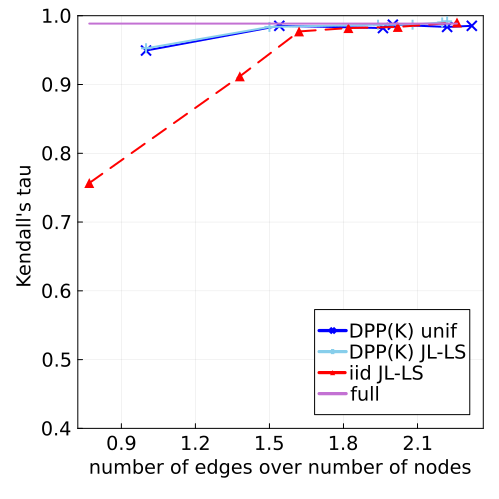

┌ Warning: Skipped yaxis arg linear
└ @ Plots /Users/mfanuel/.julia/packages/Plots/sxUvK/src/axes.jl:76


"syncrank_tau_MUNn50p0.1eta0.1q0"

In [182]:
# plotting Kendall's tau between rankings

metric= "tau" 
y_limits = (0.4, 1.)

legendposition=:bottomright
plot_comparison_sync(metric,D_results,y_limits;legendposition,methods)

name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
#savefig("figures/"*name*".pdf")

In [239]:
# graph parameters
n = 500#100
p = 0.1#0.9
eta = 0.1#1e-3#1e-3

# planted ranking score
planted_score = randperm(rng,n)

# graph model
if type=="MUN"
    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
elseif type=="ERO"
    meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
end

{500, 12437} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [240]:
n = nv(meta_g)

nb_samples = 50

nb_edges = zeros(nb_samples)
nb_cc = zeros(nb_samples)

cc_with_1_cycle = zeros(nb_samples)
cc_with_0_cycle = zeros(nb_samples)
cc_with_more_than_1_cycle = zeros(nb_samples)


time = zeros(nb_samples)
time_mtsf = zeros(nb_samples)

sparseB = sp_magnetic_incidence(meta_g; oriented=true)

V = Matrix(qr(Matrix(sparseB)).Q)

for i_sample in 1:nb_samples

    id, t = @timed sample_pdpp(V)
    e = collect(edges(meta_g))
    subgraph,_ = induced_subgraph(meta_g, e[id])

    nb_edges[i_sample] = ne(subgraph)
    cc = connected_components(subgraph)

    nb_cc[i_sample] = length(cc)

    cc = [induced_subgraph(subgraph, cc)[1] for cc in connected_components(subgraph)]

    temp_cc_with_1_cycle = 0
    temp_cc_with_0_cycle = 0
    temp_cc_with_more_than_1_cycle = 0

    for i in cc
        l = length(cycle_basis(i))
        if l == 1
            temp_cc_with_1_cycle += 1
        elseif l == 0
            temp_cc_with_0_cycle += 1
        else
            temp_cc_with_more_than_1_cycle += 1
        end
    end

    cc_with_1_cycle[i_sample] = temp_cc_with_1_cycle
    cc_with_0_cycle[i_sample] = temp_cc_with_0_cycle
    cc_with_more_than_1_cycle[i_sample] = temp_cc_with_more_than_1_cycle

    time[i_sample] = t
    mtsf, t_mtsf = @timed multi_type_spanning_forest(rng, meta_g, q)
    time_mtsf[i_sample] = t_mtsf

end    

println(cc_with_1_cycle)
println(cc_with_0_cycle)
println(cc_with_more_than_1_cycle)
println(nb_cc)
println([mean(time) mean(time_mtsf)])

[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 2.0, 4.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 3.0, 2.0, 3.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 3.0, 0.0, 0.0, 3.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 3.0, 1.0, 2.0]
[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
[2.0, 1.0, 2.0, 3.0, 1.0, 3.0, 3.0, 2.0, 3.0, 4.0, 6.0, 2.0, 1.0, 1.0, 3.0, 3.0, 2.0, 1.0, 2.0, 4.0, 2.0, 2.0, 2.0, 3.0, 2.0, 3.0, 2.0, 2.0, 4.0, 3.0, 4.0, 1.0, 2.0, 2.0, 4.0, 3.0, 2.0, 3.0, 1.0, 1.0, 6.0, 3.0, 2.0, 4.0, 2.0, 2.0, 3.0, 3.0, 1.0, 2

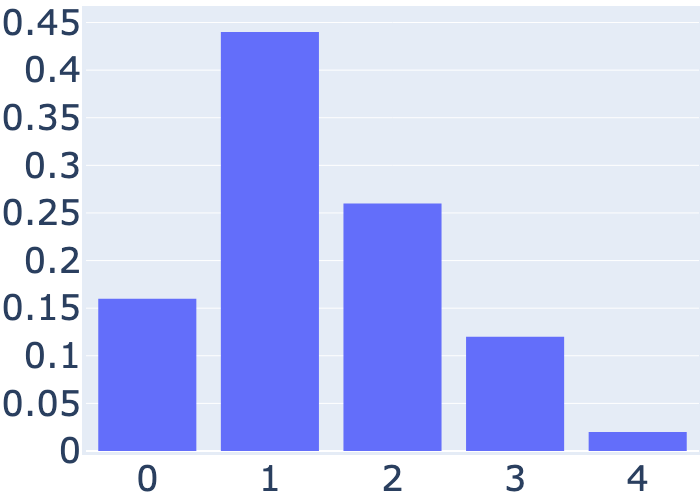

In [241]:
cat_nb_cc_1_cycle = string.(sort(Int.(cc_with_1_cycle)))
trace = PlotlyJS.histogram(x=cat_nb_cc_1_cycle, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
p_1 = PlotlyJS.plot(trace,layout)

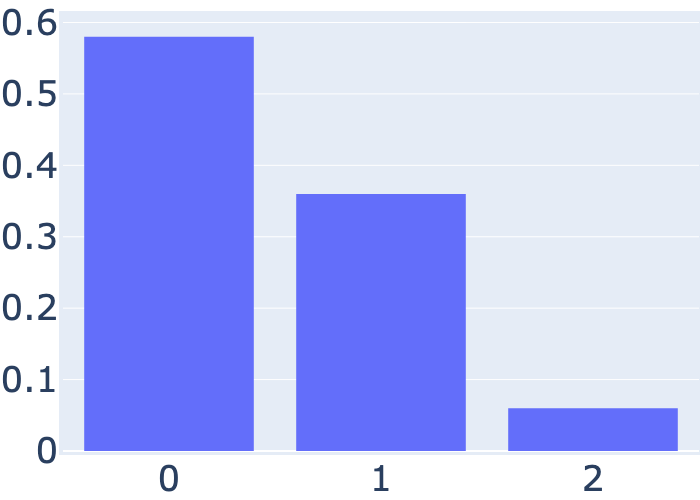

In [242]:
cat_nb_cc_0_cycle = string.(sort(Int.(cc_with_0_cycle)))
trace = PlotlyJS.histogram(x=cat_nb_cc_0_cycle, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
p_0 = PlotlyJS.plot(trace,layout)

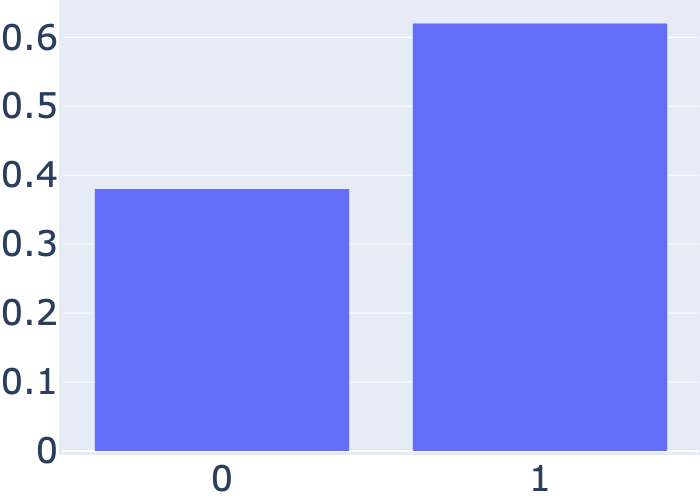

In [243]:
cat_nb_cc_with_more_than_1_cycle = string.(sort(Int.(cc_with_more_than_1_cycle
)))
trace = PlotlyJS.histogram(x=cat_nb_cc_with_more_than_1_cycle, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
p_more_than_1 = PlotlyJS.plot(trace,layout)

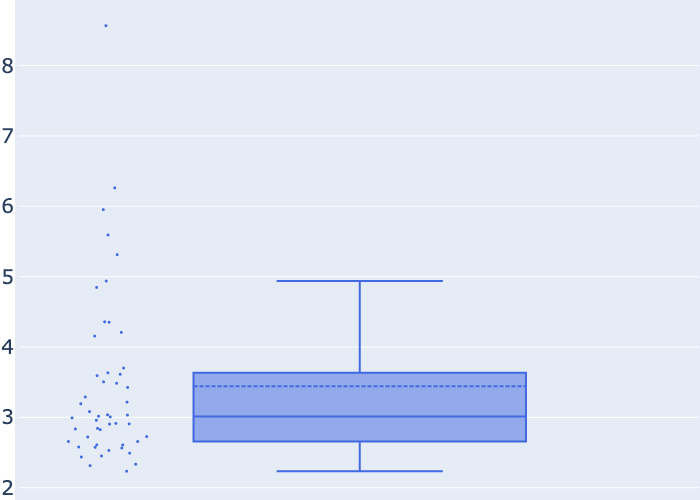

In [244]:
trace = box(y=(time),
boxpoints="all",
marker=attr(
        color="LightSkyBlue",
        size=3),
quartilemethod="linear",
name="",
marker_color="royalblue",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
)
p_time_hkpv = PlotlyJS.plot(trace,layout)

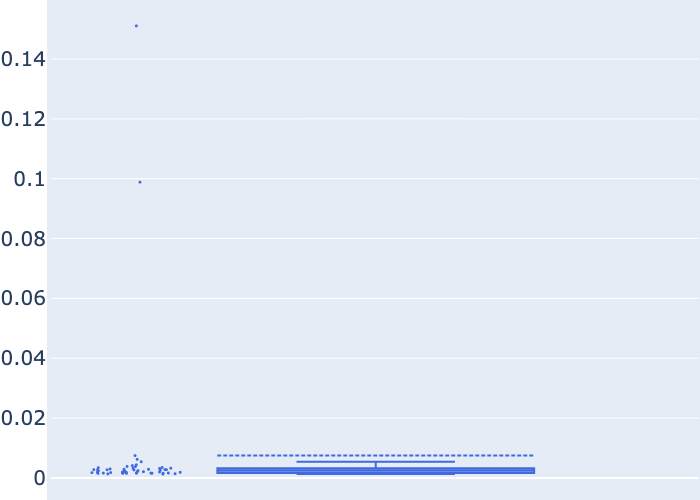

In [245]:
trace = box(y=(time_mtsf),
boxpoints="all",
marker=attr(
        color="LightSkyBlue",
        size=3),
quartilemethod="linear",
name="",
marker_color="royalblue",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
)
p_time_hkpv = PlotlyJS.plot(trace,layout)

In [188]:
id, t = @timed sample_pdpp(V)
e = collect(edges(meta_g))
subgraph, vmap = induced_subgraph(meta_g, e[id])

# cc = [induced_subgraph(subgraph, cc)[1] for cc in connected_components(subgraph)]
# cc

println(cycle_basis(subgraph))
println(length(connected_components(subgraph)))

[[10, 8, 9, 40, 17, 15, 12]]
1


In [71]:
id, t = @timed sample_pdpp(V)
e = collect(edges(meta_g))
subgraph, vmap = induced_subgraph(meta_g, e[id])

cc = connected_components(subgraph)

# cc = [induced_subgraph(subgraph, cc)[1] for cc in connected_components(subgraph)]

4-element Vector{Vector{Int64}}:
 [1, 2, 14]
 [3, 4, 5, 6, 7, 8, 9, 10, 11, 12  …  38, 39, 40, 41, 44, 45, 46, 47, 48, 49]
 [36, 37]
 [42, 43]

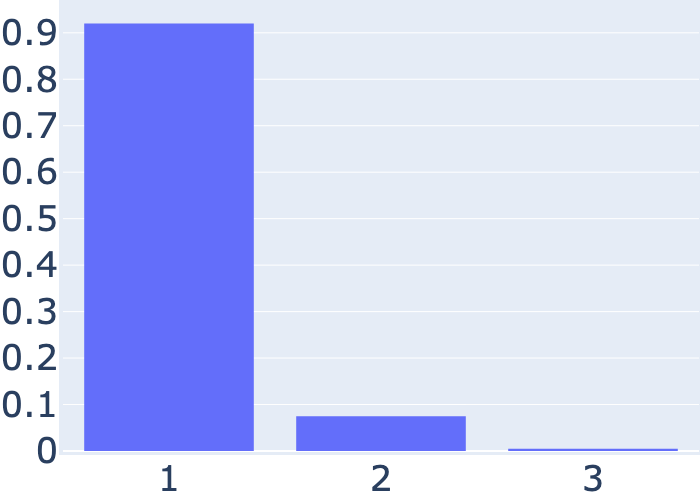

In [37]:
nb_samples = 200
nb_cycles = zeros(nb_samples)
mtsf_weight = zeros(nb_samples)

for i_sample in 1:nb_samples
    mtsf = multi_type_spanning_forest(rng, meta_g, q)

    # check nb roots and cycles
    cycles = get_prop(mtsf, :cycle_nodes)
    nb_cycles[i_sample] = length(cycles)
    D = props(mtsf)
    w = D[:weight]
    mtsf_weight[i_sample] = w
    
end    

cat_nb_cycles = string.(sort(Int.(nb_cycles)))
trace = PlotlyJS.histogram(x=cat_nb_cycles, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
p = PlotlyJS.plot(trace,layout)

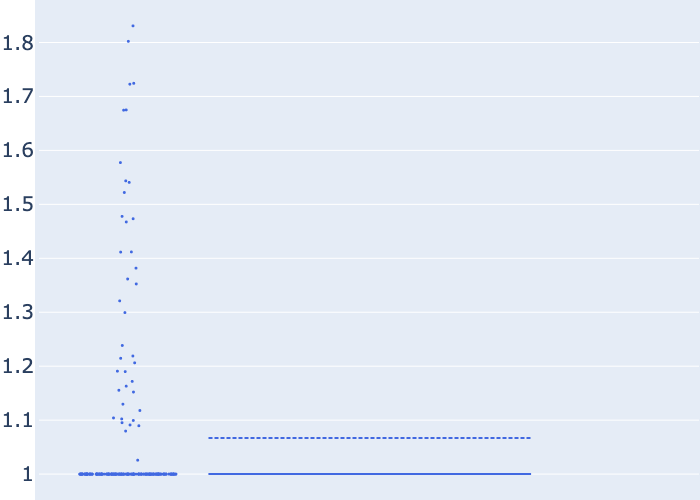

In [39]:
trace = box(y=(mtsf_weight),
boxpoints="all",
marker=attr(
        color="LightSkyBlue",
        size=3),
quartilemethod="linear",
name="",
marker_color="royalblue",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
)
PlotlyJS.plot(trace,layout)

name = "syncrank_"*"weight_of_MTSF"*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

plt = PlotlyJS.plot(trace,layout)
#PlotlyJS.savefig(plt,"figures/"*name*".pdf")

 ERO graph model

least eigval of Laplacian= 0.014139560614056901
k = 

342 vs nb edges= 4946
 
method: DPP(K) unif


least eigenvalue of sparsifier: 4.642813191018992e-5
least eigenvalue of sparsifier: 

0.005261282407902249


least eigenvalue of sparsifier: 0.010385370196225926
least eigenvalue of sparsifier: 

0.013397310908768941


least eigenvalue of sparsifier: 0.011853308994355542
least eigenvalue of sparsifier: 

0.012366360647171316


least eigenvalue of sparsifier: 0.013789260422861865
method: 

DPP(K) JL-LS


least eigenvalue of sparsifier: 2.2258832714650197e-5
least eigenvalue of sparsifier: 

0.008384600347217294


least eigenvalue of sparsifier: 0.010292781400454015
least eigenvalue of sparsifier: 

0.011652468527590411


least eigenvalue of sparsifier: 0.011377314631642767
least eigenvalue of sparsifier: 

0.011686459113602492


least eigenvalue of sparsifier: 0.013083065099627604
method: 

iid JL-LS
least eigenvalue of sparsifier: 1.037338598339495e-8
least eigenvalue of sparsifier: 

6.47098657927367e-6


least eigenvalue of sparsifier: 1.2509669655835112e-5
least eigenvalue of sparsifier: 

0.002175533805107899


least eigenvalue of sparsifier: 0.008354766421221833


least eigenvalue of sparsifier: 

0.010203139858426387


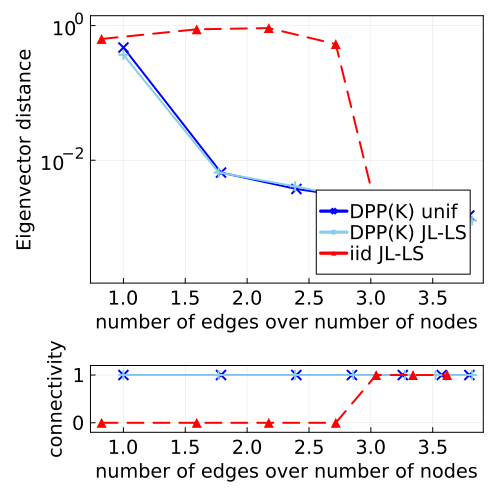

least eigenvalue of sparsifier: 0.010699938797123651


"syncrank_err_EROn1000p0.01eta0.02q0"

In [109]:
type = "ERO" 

rng = Random.default_rng()

# graph parameters
n = 1000
p = 0.01
eta = 0.02

# planted ranking score
planted_score = randperm(rng,n)

# graph model
if type=="MUN"
    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
elseif type=="ERO"
    meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
end

# simulation parameters
n_batch = 7 # maximum number of batches considered
n_rep = 1 # number of runs

# regularization parameter
q = 0

# storing settings
D_params = Dict("n" => n,"p" => p,"eta" => eta,"q" => q,"n_batch" => n_batch,"n_rep" => n_rep)

# print least eigenvalues
# B = magnetic_incidence(meta_g)
# l = eigvals(B' * B)
# println("least eigenvalue: ", l[1:3])

methods = [
    "DPP(K) unif",
    "DPP(K) JL-LS",
    #"DPP(K) LS",
    "iid JL-LS",
    # "iid LS",
    #"ST JL-LS",
    # "ST LS",
]

check_connected = true
hkpv = false
D_results = benchmark_syncrank(meta_g,planted_score, n_batch, n_rep, rng; methods, hkpv)
# plotting distance between eigenvectors
metric= "err"
y_limits = (1.5*1e-4, 1.4)
legendposition=:bottomright
plot_comparison_sync(metric,D_results,y_limits;legendposition,methods,check_connected)
name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# # saving plot
# savefig("figures/"*name*".pdf")

# # saving results
# save("figures/"*name*"_data.jld", "D_results", D_results,"D_params", D_params)

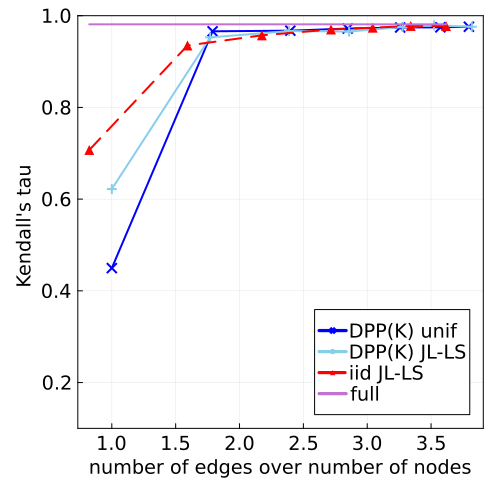

┌ Warning: Skipped yaxis arg linear
└ @ Plots /Users/mfanuel/.julia/packages/Plots/sxUvK/src/axes.jl:76


"syncrank_tau_EROn1000p0.01eta0.02q0"

In [110]:
# plotting Kendall's tau between rankings

metric= "tau" 

y_limits = (0.1, 1.)

legendposition=:bottomright
plot_comparison_sync(metric,D_results,y_limits;legendposition,methods)

name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
#savefig("figures/"*name*".pdf")

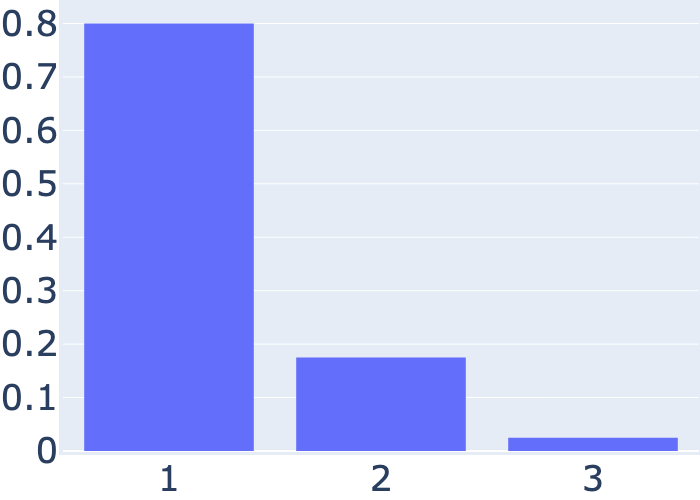

In [111]:
nb_samples = 200
nb_cycles = zeros(nb_samples)
mtsf_weight = zeros(nb_samples)

for i_sample in 1:nb_samples
    mtsf = multi_type_spanning_forest(rng, meta_g, q)

    # check nb roots and cycles
    cycles = get_prop(mtsf, :cycle_nodes)
    nb_cycles[i_sample] = length(cycles)
    D = props(mtsf)
    w = D[:weight]
    mtsf_weight[i_sample] = w
end    

cat_nb_cycles = string.(sort(Int.(nb_cycles)))
trace = PlotlyJS.histogram(x=cat_nb_cycles, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
p = PlotlyJS.plot(trace,layout)

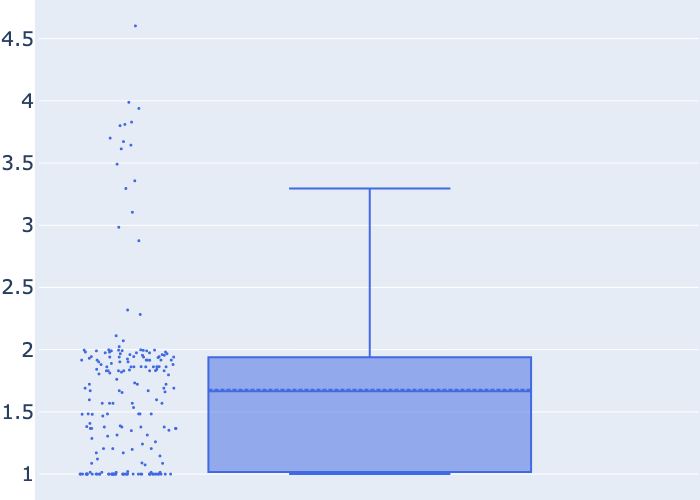

In [112]:
trace = box(y=(mtsf_weight),
boxpoints="all",
marker=attr(
        color="LightSkyBlue",
        size=3),
quartilemethod="linear",
name="",
marker_color="royalblue",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
)
PlotlyJS.plot(trace,layout)

name = "syncrank_"*"weight_of_MTSF"*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

plt = PlotlyJS.plot(trace,layout)
#PlotlyJS.savefig(plt,"figures/"*name*".pdf")

SBM MUN


In [ ]:
rng = Random.default_rng()

# graph parameters
n = 400
p_in = 0.2
p_out = 0.001
η = 0.1
#noise = 0.3

# planted ranking score
planted_score = randperm(rng,n)


meta_g = MetaGraph(n)
ic = false
while !ic
    if type=="MUN"
        meta_g = ero_mun_sbm(rng,n,p_in,p_out,η,noise;planted_score)
    elseif type=="ERO"
        meta_g = ero_mun_sbm(rng,n,p_in,p_out,η,noise;planted_score)
    end
    ic = is_connected(meta_g)
end
println("connected graph generated with m/n = ", ne(meta_g) / nv(meta_g))



# simulation parameters
n_batch = 7 # maximum number of batches considered
n_rep = 1 # number of runs

# regularization parameter
q = 0

# # storing settings
# D_params = Dict("n" => n,"p" => p,"eta" => eta,"q" => q,"n_batch" => n_batch,"n_rep" => n_rep)


methods = [
    "DPP(K) unif",
    "DPP(K) JL-LS",
    #"DPP(K) LS",
    "iid JL-LS",
    # "iid LS",
    #"ST JL-LS",
    # "ST LS",
]

D_results = benchmark_syncrank(meta_g,planted_score, n_batch, n_rep, rng; methods)
# plotting distance between eigenvectors
metric= "err"
y_limits = (1.5*1e-4, 1.4)
legendposition=:topright
plot_comparison_sync(metric,D_results,y_limits;legendposition,methods)
name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")

In [ ]:
# plotting Kendall's tau between rankings

metric= "tau" 
y_limits = (1.5*1e-4, 1.1)

legendposition=:bottomright
plot_comparison_sync(metric,D_results,y_limits;legendposition,methods)

name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")